# IMERG aggregation

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import ocha_stratus as stratus
import pandas as pd
import geopandas as gpd
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar
from rasterio.errors import RasterioIOError

from src.datasources import codab, imerg
from src.constants import *

## Load data

### CODAB

In [3]:
# codab.download_codab_to_blob()

In [4]:
adm0 = codab.load_codab_from_blob()

In [5]:
adm0

,ADM0_EN,ADM0_PCODE,DATE,VALIDON,VALIDTO,geometry
0,Philippines (the),PH,2022-11-09,2023-11-06,NaT,"MULTIPOLYGON (((119.20571 4.66963, 119.20568 4..."


<Axes: >

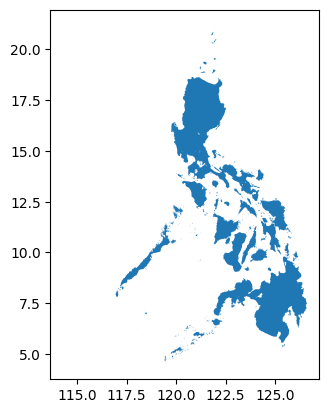

In [6]:
adm0.plot()

### IBTrACS

In [7]:
query = """
SELECT * 
FROM storms.ibtracs_tracks_geo
WHERE basin = 'WP'
"""
with stratus.get_engine(stage="prod").connect() as con:
    gdf_tracks = gpd.read_postgis(query, con, geom_col="geometry")

In [8]:
query = """
SELECT *
FROM storms.ibtracs_storms
"""
with stratus.get_engine(stage="prod").connect() as con:
    df_storms = pd.read_sql(query, con)

In [9]:
gdf_tracks = gdf_tracks.merge(df_storms)

In [10]:
gdf_tracks_recent = gdf_tracks[gdf_tracks["season"] >= 2000].copy()

## Processing

### Filter by distance

In [11]:
adm0_3857 = adm0.to_crs(3857)
target_geom = adm0_3857.geometry.iloc[0]
gdf_tracks_recent_3857 = gdf_tracks_recent.to_crs(3857)

In [12]:
distances = []

for geom in tqdm(gdf_tracks_recent_3857.geometry):
    distances.append(geom.distance(target_geom))

gdf_tracks_recent["distance_m"] = distances

  0%|          | 0/23188 [00:00<?, ?it/s]

<Axes: >

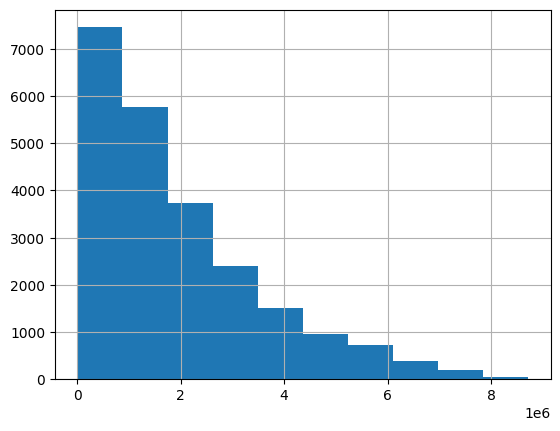

In [13]:
gdf_tracks_recent["distance_m"].hist()

In [14]:
d_thresh = 50

In [15]:
adm0_3857_buffer230 = adm0_3857.buffer(d_thresh * 1000)

In [16]:
gdf_tracks_close = gdf_tracks_recent[
    gdf_tracks_recent["distance_m"] <= d_thresh * 1000
].copy()

In [17]:
df_tracks_agg = (
    gdf_tracks_close.groupby("sid")
    .agg(
        valid_time_min=("valid_time", "min"),
        valid_time_max=("valid_time", "max"),
        wind_speed_max=("wind_speed", "max"),
    )
    .reset_index()
).dropna()

In [18]:
df_tracks_agg

,sid,valid_time_min,valid_time_max,wind_speed_max
2,2000248N18126,2000-09-10 06:00:00,2000-09-11 12:00:00,45.0
3,2000299N08139,2000-10-27 18:00:00,2000-10-28 18:00:00,60.0
4,2000305N06136,2000-11-02 06:00:00,2000-11-03 00:00:00,55.0
6,2001125N05129,2001-05-09 12:00:00,2001-05-13 00:00:00,50.0
7,2001170N11138,2001-06-22 06:00:00,2001-06-22 06:00:00,60.0
...,...,...,...,...
186,2025267N10134,2025-09-25 18:00:00,2025-09-26 06:00:00,60.0
187,2025274N15131,2025-10-03 00:00:00,2025-10-03 06:00:00,64.0
188,2025291N13126,2025-10-18 06:00:00,2025-10-19 06:00:00,35.0
189,2025305N10138,2025-11-03 12:00:00,2025-11-05 00:00:00,89.0


In [19]:
quantiles = [0.8, 0.9, 0.95]


def get_storm_rainfall_aggregations(row):
    row = row.copy()
    min_date = row["valid_time_min"].date() - pd.DateOffset(days=1)
    max_date = row["valid_time_max"].date() + pd.DateOffset(days=1)
    dates = pd.date_range(min_date, max_date)
    da = imerg.open_imerg_raster_dates(dates)
    da_clip = da.rio.clip(adm0.geometry)

    # 2-day rolling sum
    da_rolling2 = da_clip.rolling(date=2).sum()
    # 3-day rolling sum
    da_rolling3 = da_clip.rolling(date=3).sum()

    # take quantiles
    for quantile in quantiles:
        for da_agg, agg_str in [
            (da_rolling2, "roll2"),
            (da_rolling3, "roll3"),
        ]:
            # get quantile threshs
            quantile_threshs = da_agg.quantile(quantile, dim=["x", "y"])
            # get max value
            row[f"q{quantile*100:.0f}_{agg_str}"] = float(
                quantile_threshs.max()
            )

    return row

In [20]:
import warnings

warnings.filterwarnings("ignore", message="All-NaN slice encountered")

In [ ]:
get_storm_rainfall_aggregations(df_tracks_agg.iloc[0])

In [22]:
tqdm.pandas()

In [ ]:
df_tracks_agg = df_tracks_agg.progress_apply(
    get_storm_rainfall_aggregations, axis=1
)

In [26]:
df_tracks_agg

,sid,valid_time_min,valid_time_max,wind_speed_max,q80_roll2,q80_roll3,q90_roll2,q90_roll3,q95_roll2,q95_roll3
2,2000248N18126,2000-09-10 06:00:00,2000-09-11 12:00:00,45.0,45.054001,58.357998,88.719994,98.764496,122.616997,136.360245
3,2000299N08139,2000-10-27 18:00:00,2000-10-28 18:00:00,60.0,165.409988,209.722000,224.842987,290.563507,279.513733,349.203461
4,2000305N06136,2000-11-02 06:00:00,2000-11-03 00:00:00,55.0,104.563995,131.760010,203.577957,229.390518,294.647766,338.187714
6,2001125N05129,2001-05-09 12:00:00,2001-05-13 00:00:00,50.0,75.133995,97.445000,119.209991,137.260498,160.666977,176.315735
7,2001170N11138,2001-06-22 06:00:00,2001-06-22 06:00:00,60.0,66.177994,81.712006,96.375496,123.316994,136.060989,157.362991
...,...,...,...,...,...,...,...,...,...,...
186,2025267N10134,2025-09-25 18:00:00,2025-09-26 06:00:00,60.0,97.699997,105.072998,152.252502,161.379501,178.669998,186.904739
187,2025274N15131,2025-10-03 00:00:00,2025-10-03 06:00:00,64.0,88.656998,91.140991,106.903000,109.906982,120.015488,123.223999
188,2025291N13126,2025-10-18 06:00:00,2025-10-19 06:00:00,35.0,84.789986,93.028000,113.498497,123.448509,159.110992,167.795258
189,2025305N10138,2025-11-03 12:00:00,2025-11-05 00:00:00,89.0,118.521011,130.082993,149.364990,159.100006,180.468491,185.976715


In [ ]:
blob_name = f"{PROJECT_PREFIX}/processed/ibtracs_imerg_stats_50km.parquet"
stratus.upload_parquet_to_blob(df_tracks_agg, blob_name)